## Identify highly variable genes ignoring spatial context and Identify genes differentially expressed between spatial domains with DESeq2

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../../scGCO_code/')

In [2]:
from scGCO_source import *
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
%matplotlib inline



## Supple_Fig11a :　compare with DESeq2 and high variable results

In [3]:
result_df= read_result_to_dataframe('../../../results/MouseOB/scGCO_results/Rep11_result_df.csv')

# this is the SV genes identified bu scGCO
fdr_df = result_df[result_df.fdr < 0.01].sort_values(by=['fdr'])
print('Rep11 SV genes identified by scGCO: ',fdr_df.shape)


Rep11 SV genes identified by scGCO:  (481, 267)


In [6]:
deseq2_df=pd.read_csv("../../../data/MOB_DESeq2_results/Rep11_MOB_DESeq2_fc1_df.csv",
                      index_col=0)
print('Rep11 different expression genes calculated by DESeq2:  ', deseq2_df.shape)

Rep11 different expression genes calculated by DESeq2:   (1798, 1)


In [5]:
hvg_df=pd.read_csv("../../../data/HighVariableGenes/Rep11_MOB_hvg.csv",header=None,index_col=0)
print('Rep11 high variable genes:  ', hvg_df.shape)

Rep11 high variable genes:   (2894, 0)


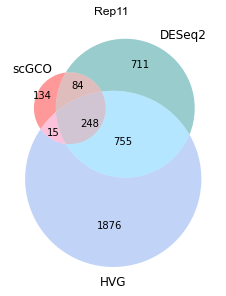

In [7]:

figure, axes = plt.subplots(constrained_layout=True)  

titleText = 'Rep11 '


vn=venn3(subsets=[set(fdr_df.index),
               set(deseq2_df.index.values),
               set(hvg_df.index.values)],
               set_labels = ('scGCO', 'DESeq2',"HVG"), 
                 set_colors=('r','teal','cornflowerblue'),
               ax=axes)
#         lbl_A= vn.get_label_by_id("A")
#         xx, yy = lbl_A.get_position()
#         lbl_A.set_position((xx, yy-0.85)) 

#         lbl_B= vn.get_label_by_id("B")
#         xx, yy = lbl_B.get_position()
#         lbl_B.set_position((xx, yy-0.95)) 

axes.set_title(titleText, fontname="Arial", fontsize=12)
plt.savefig("../../../results/Figure/Supple_Fig11a.pdf",format="pdf",dpi=600)
plt.show()

## Supple_Fig11b

In [ ]:
# Compare the Cumulative Distribution Function(cdf) of hamming distance with three SV genes sets 

j=11
unary_scale_factor=100
label_cost=10
algorithm='expansion'
ff = '../../../data/Raw_data/MOB-breast_cancer/Rep' + str(j) +  '_MOB_count_matrix-1.tsv'
locs,data,noiseInd =read_spatial_expression(ff,sep='\t', drop=True)

data_norm = normalize_count_cellranger(data)
print('Rep{}_processing: {}'.format(j,data_norm.shape))

exp=data_norm.iloc[:,1].values
cellGraph=create_graph_with_weight(locs,exp)

## get tissue mat
with open('../../../Temp_files/tissue_mat/Rep'+str(j)+'_tissue_mat_sorted.plk','rb') as f:
    tissue_mat_sorted = pickle.load(f)
    
    
result_df_new = read_result_to_dataframe(
    '../../../results/MouseOB/scGCO_results/Rep'+str(j)+'_result_df.csv')
result_df = update_result_df_delPoints(result_df_new,noiseInd)

fdr_cut=0.01
fdr_df=result_df.loc[result_df.fdr< fdr_cut]
scGCO_list  = fdr_df.index.values
#     print(fdr_df.shape)

## DESeq2
deseq2_list= deseq2_df.index.values

## HVGs
hvg_list= hvg_df.index.values

scGCO_only = (set(scGCO_list)- set(deseq2_list)-set(hvg_list))
DESeq2_only = (set(deseq2_list)-set(scGCO_list)-set(hvg_list))
HVG_only=(set(hvg_list)-set(scGCO_list)-set(deseq2_list))
common =(set(scGCO_list) & set(deseq2_list) & set(hvg_list))
#     common2_3 = set(np.unique(list(set(scGCO_list)|set(deseq2_list)|set(hvg_list)))) - (set(scGCO_only)|set(DESeq2_only)|set(HVG_only)) 
List_df=['scGCO_only','DESeq2_only','HVG_only','common']


### compare tissue_mat for getting hamming, Jaccard and Hausdorff df  
for listName in List_df:
    geneList= eval(listName)
    geneList = list(set(geneList) & set(result_df.index))
    calc_df= result_df.loc[geneList,]
    print(listName, calc_df.shape)
    dist_df,_ = calc_distance_df(locs, data_norm, cellGraph,
                                    gmmDict, calc_df , tissue_mat_sorted, sort_tissue=True)
    dist_df.to_csv(
        '../../../results/MouseOB/scGCO_results/MOB-Distance_df-DESeq2_HVG/Rep{}_{}_dist_df_DESeq2_HVG.csv'.format(j,listName))


## negative curve with random expression profiles
data_norm_rand = shuffle(data_norm)

exp_rand = data_norm_rand.iloc[:,0].values
cellGraph_rand = create_graph_with_weight(locs, exp_rand)
gmmDict = [] #multiGMM(data_norm_calc)

calc_df_rand = identify_spatial_genes_fixed_sf(locs, data_norm_rand, cellGraph_rand,
                                               gmmDict, smooth_factor=30, use_otsu=True)

dist_df,_ = calc_distance_df(locs, data_norm_rand, cellGraph_rand,
                                    calc_df_rand , tissue_mat_sorted, sort_tissue=True)
dist_df.to_csv(
        '../../../results/MouseOB/scGCO_results/MOB-Distance_df-DESeq2_HVG/Rep'+str(j)+'_negative_dist_data_norm.csv')



0.8364583333333335
0.7314692982456141
10.495485911519367


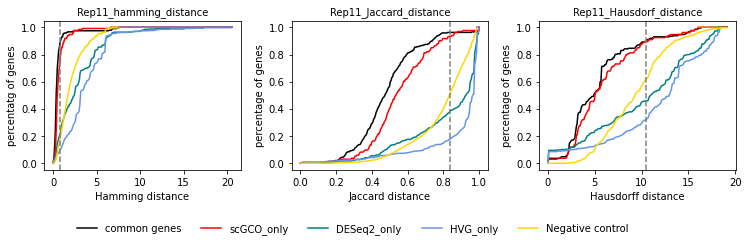

In [9]:
List_df=['scGCO_only','DESeq2_only','HVG_only','common']

nrows=1
ncols=3
fig,ax = plt.subplots(nrows, ncols, figsize=(ncols*3.5, nrows*3))

 
j=11
scgco_dist =pd.read_csv(
    '../../../results/MouseOB/scGCO_results/MOB-Distance_df-DESeq2_HVG/Rep{}_{}_dist_df_DESeq2_HVG.csv'.format(j,List_df[0]))
deseq2_dist =pd.read_csv(
    '../../../results/MouseOB/scGCO_results/MOB-Distance_df-DESeq2_HVG/Rep{}_{}_dist_df_DESeq2_HVG.csv'.format(j,List_df[1])) 
hvg_dist = pd.read_csv(
    '../../../results/MouseOB/scGCO_results/MOB-Distance_df-DESeq2_HVG/Rep{}_{}_dist_df_DESeq2_HVG.csv'.format(j,List_df[2]))
common_dist =pd.read_csv(
    '../../../results/MouseOB/scGCO_results/MOB-Distance_df-DESeq2_HVG/Rep{}_{}_dist_df_DESeq2_HVG.csv'.format(j,List_df[3]))
neg_curve = pd.read_csv(
    '../../../results/MouseOB/scGCO_results/MOB-Distance_df-DESeq2_HVG/Rep11_negative_dist_data_norm.csv')

cdf_scgco=cumcdf(scgco_dist.Hamming.values,num_bin=200)
cdf_deseq2=cumcdf(deseq2_dist.Hamming.values,num_bin=200)
cdf_hvg=cumcdf(hvg_dist.Hamming.values,num_bin=200)
cdf_co3=cumcdf(common_dist.Hamming.values,num_bin=200)
# cdf_co2=cumcdf(common_dist2.Hamming.values,num_bin=200)
cdf_neg = cumcdf(neg_curve.Hamming.values, num_bin=200)

max_x= max(cdf_scgco[0][-1], cdf_deseq2[0][-1], cdf_hvg[0][-1], cdf_co3[0][-1],cdf_neg[0][-1])
max_y= max(cdf_scgco[1][-1], cdf_deseq2[1][-1], cdf_hvg[1][-1], cdf_co3[1][-1],cdf_neg[1][-1])

ax[0].plot(np.append(0,cdf_co3[0]),np.append(0, cdf_co3[1]),c='k',label='common genes')   
ax[0].plot(np.append(cdf_co3[0][-1], max_x), np.append(cdf_co3[1][-1], max_y))

ax[0].plot(np.append(0,cdf_scgco[0]),np.append(0, cdf_scgco[1]),c='r',label=List_df[0])
ax[0].plot(np.append(cdf_scgco[0][-1], max_x), np.append(cdf_scgco[1][-1], max_y))

ax[0].plot(np.append(0,cdf_deseq2[0]),np.append(0, cdf_deseq2[1]),c='teal',label=List_df[1]) 
ax[0].plot(np.append(cdf_deseq2[0][-1], max_x), np.append(cdf_deseq2[1][-1], max_y))

ax[0].plot(np.append(0,cdf_hvg[0]),np.append(0, cdf_hvg[1]),c='cornflowerblue',label=List_df[2])
ax[0].plot(np.append(cdf_hvg[0][-1], max_x), np.append(cdf_hvg[1][-1], max_y))     

ax[0].plot(np.append(0,cdf_neg[0]),np.append(0, cdf_neg[1]),c='gold',label='Negative control')   
ax[0].plot(np.append(cdf_neg[0][-1], max_x), np.append(cdf_neg[1][-1], max_y))

hamming_cutoff = np.quantile(common_dist.Hamming.values,q = 0.9)
print(hamming_cutoff)
ax[0].axvline(hamming_cutoff, ls='--', c='grey')
ax[0].set_title('Rep{}_hamming_distance'.format(j), fontsize=10)
ax[0].set_xlabel('Hamming distance')#,fontsize=15)
ax[0].set_ylabel('percentatg of genes')#,fontsize=15)



cdf_scgco=cumcdf(scgco_dist.Jaccard.values,num_bin=200)
cdf_deseq2=cumcdf(deseq2_dist.Jaccard.values,num_bin=200)
cdf_hvg=cumcdf(hvg_dist.Jaccard.values,num_bin=200)
cdf_co3=cumcdf(common_dist.Jaccard.values,num_bin=200)
# cdf_co2=cumcdf(common_dist2.Jaccard.values,num_bin=200)
cdf_neg = cumcdf(neg_curve.Jaccard.values, num_bin=200)

max_x= max(cdf_scgco[0][-1], cdf_deseq2[0][-1], cdf_hvg[0][-1], cdf_co3[0][-1],cdf_neg[0][-1])
max_y= max(cdf_scgco[1][-1], cdf_deseq2[1][-1], cdf_hvg[1][-1], cdf_co3[1][-1],cdf_neg[1][-1])

ax[1].plot(np.append(0,cdf_co3[0]),np.append(0, cdf_co3[1]),c='k',label='common genes')   
ax[1].plot(np.append(cdf_co3[0][-1], max_x), np.append(cdf_co3[1][-1], max_y))

ax[1].plot(np.append(0,cdf_scgco[0]),np.append(0, cdf_scgco[1]),c='r',label=List_df[0])
ax[1].plot(np.append(cdf_scgco[0][-1], max_x), np.append(cdf_scgco[1][-1], max_y))

ax[1].plot(np.append(0,cdf_deseq2[0]),np.append(0, cdf_deseq2[1]),c='teal',label=List_df[1])
ax[1].plot(np.append(cdf_deseq2[0][-1], max_x), np.append(cdf_deseq2[1][-1], max_y))

ax[1].plot(np.append(0,cdf_hvg[0]),np.append(0, cdf_hvg[1]),c='cornflowerblue',label=List_df[2])
ax[1].plot(np.append(cdf_hvg[0][-1], max_x), np.append(cdf_hvg[1][-1], max_y))

ax[1].plot(np.append(0,cdf_neg[0]),np.append(0, cdf_neg[1]),c='gold',label='Negative control')   
ax[1].plot(np.append(cdf_neg[0][-1], max_x), np.append(cdf_neg[1][-1], max_y))

jaccard_cutoff = np.quantile(common_dist.Jaccard.values,q = 0.9)
print(jaccard_cutoff)
ax[1].axvline(hamming_cutoff, ls='--', c='grey')

ax[1].set_title('Rep{}_Jaccard_distance'.format(j))

ax[1].set_xlabel('Jaccard distance')
ax[1].set_ylabel('percentage of genes')
#     ax.axvline(cutoff_ja,ls='--',c='grey')

ax[1].set_title('Rep'+str(j)+'_Jaccard_distance',fontsize=10)



cdf_scgco=cumcdf(scgco_dist.Hausdorff.values,num_bin=200)
cdf_deseq2=cumcdf(deseq2_dist.Hausdorff.values,num_bin=200)
cdf_hvg=cumcdf(hvg_dist.Hausdorff.values,num_bin=200)
cdf_co3=cumcdf(common_dist.Hausdorff.values,num_bin=200)
# cdf_co2=cumcdf(common_dist2.Hausdorff.values,num_bin=200)
cdf_neg = cumcdf(neg_curve.Hausdorff.values, num_bin=200)

max_x= max(cdf_scgco[0][-1], cdf_deseq2[0][-1], cdf_hvg[0][-1], cdf_co3[0][-1],cdf_neg[0][-1])
max_y= max(cdf_scgco[1][-1], cdf_deseq2[1][-1], cdf_hvg[1][-1], cdf_co3[1][-1],cdf_neg[1][-1])

ax[2].plot(np.append(0,cdf_co3[0]),np.append(0, cdf_co3[1]),c='k',label='common genes')   
ax[2].plot(np.append(cdf_co3[0][-1], max_x), np.append(cdf_co3[1][-1], max_y))
# ax[2].plot(np.append(0,cdf_co2[0]),np.append(0, cdf_co2[1]),c='slategrey',label='common-2 genes')   
# ax[2].plot(np.append(cdf_co2[0][-1], max_x), np.append(cdf_co2[1][-1], max_y))

ax[2].plot(np.append(0,cdf_scgco[0]),np.append(0, cdf_scgco[1]),c='r',label=List_df[0])
ax[2].plot(np.append(cdf_scgco[0][-1], max_x), np.append(cdf_scgco[1][-1], max_y))

ax[2].plot(np.append(0,cdf_deseq2[0]),np.append(0, cdf_deseq2[1]),c='teal',label=List_df[1])
ax[2].plot(np.append(cdf_deseq2[0][-1], max_x), np.append(cdf_deseq2[1][-1], max_y))

ax[2].plot(np.append(0,cdf_hvg[0]),np.append(0, cdf_hvg[1]),c='cornflowerblue',label=List_df[2])
ax[2].plot(np.append(cdf_hvg[0][-1], max_x), np.append(cdf_hvg[1][-1], max_y))

ax[2].plot(np.append(0,cdf_neg[0]),np.append(0, cdf_neg[1]),c='gold',label='Negative control')   
ax[2].plot(np.append(cdf_neg[0][-1], max_x), np.append(cdf_neg[1][-1], max_y))

hausdorff_cutoff = np.quantile(common_dist.Hausdorff.values,q = 0.9)
print(hausdorff_cutoff)
ax[2].axvline(hausdorff_cutoff, ls='--', c='grey')

ax[2].set_title('Rep{}_Hausdorff_distance'.format(j))

ax[2].set_xlabel('Hausdorff distance')
ax[2].set_ylabel('percentage of genes')
#     ax.axvline(cutoff_ja,ls='--',c='grey')

ax[2].set_title('Rep'+str(j)+'_Hausdorf_distance',fontsize=10)

# ax[1].
plt.tight_layout()
plt.legend(frameon=False, ncol=5, bbox_to_anchor=(0.5, -0.3))
plt.savefig('../../../results/Figure//Supple_Fig11b-neg.pdf')
plt.show()

## Supple_Fig11c-d

In [10]:
sample_info=pd.read_csv("../../../data/MOB_DESeq2_results/Rep11_labels_df.csv",index_col=0)

In [11]:
ff = '../../../data/Raw_data/MOB-breast_cancer/Rep' + str(j) +  '_MOB_count_matrix-1.tsv'
locs,data,noiseInd =read_spatial_expression(ff,sep='\t', drop=True)

data_norm = normalize_count_cellranger(data)
print('Rep{}_processing: {}'.format(j,data_norm.shape))


data_norm.loc[:,"cluster"]=sample_info.cluster

raw data dim: (262, 16218)
Number of expressed genes a spot must have to be kept (0.01% of total expressed genes) 3375
Marked 3 spots
Removing genes that are expressed in less than 3 spots with a count of at least 1
Dropped 1579 genes
Rep11_processing: (259, 14639)


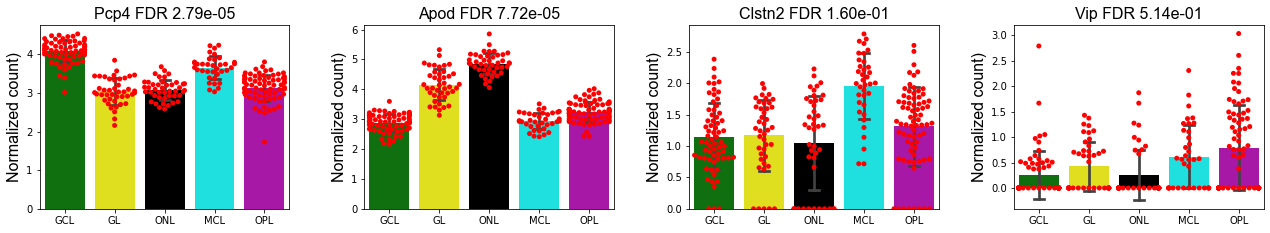

In [12]:
plot_genes=["Pcp4","Apod","Clstn2","Vip"]

fig,axes=plt.subplots(1,4,figsize=(20,3))
fig.subplots_adjust( wspace=0.3, #hspace=0.3,
                                top=0.925, right=0.925, bottom=0.075, left = 0.075)
for i, geneID in enumerate(plot_genes):
#     x = int(i/4)
    y= (i) % 4
    ax=axes[y]
    palette=["green","yellow","k","cyan","m"]
    sns.barplot(x="cluster",y=geneID,data=data_norm,ci="sd",palette=palette,capsize=.2,ax=ax)
    sns.swarmplot(x="cluster",y=geneID,data=data_norm,ax=ax,color="r")
    ax.set_xticklabels(["GCL","GL","ONL","MCL","OPL"])
    ax.set_xlabel("")
    ax.set_ylabel("Normalized count)",fontname="Arial",fontsize=16)
    ax.set_title(geneID+ " FDR {:.2e}".format(result_df.loc[geneID,"fdr"]),fontname="Arial",fontsize=16)
fig.savefig("../../../results/Figure/Supple_Fig11c-d.pdf",format="pdf",dpi=300)

## Supple_Fig11e-f

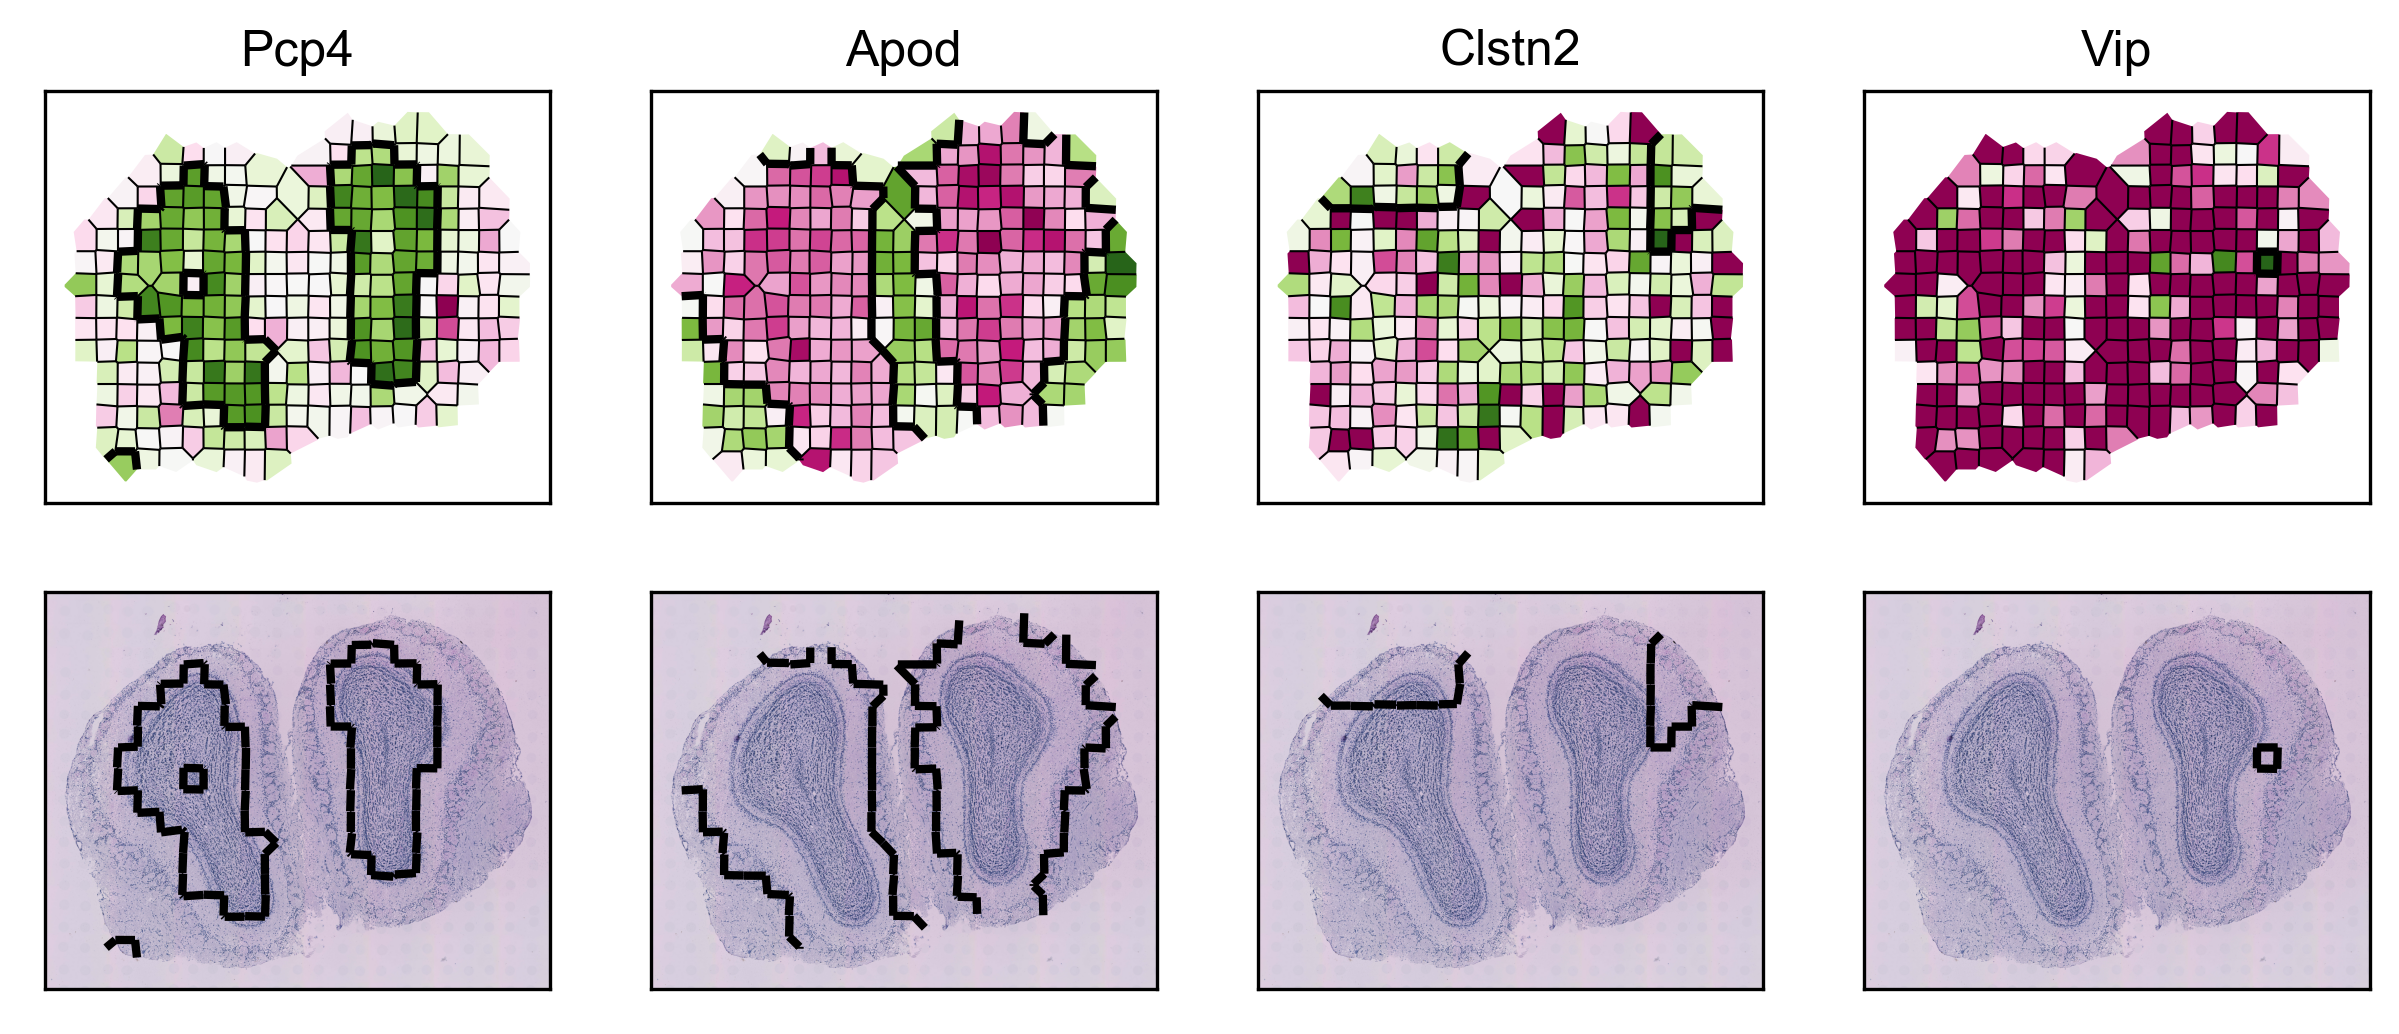

In [13]:
plot_genes=["Pcp4","Apod","Clstn2","Vip"]
fig,ax=plt.subplots(2,4,dpi=300,figsize=(10,4))
locs = Get_coord(data_norm)
for i ,geneID in enumerate(plot_genes):

    y= (i) % 4
    exp =  data_norm.loc[:,geneID]
    cellGraph = create_graph_with_weight(locs, exp)

    newLabels = result_df.loc[geneID][5:]
    p=result_df.loc[geneID,"p_value"]

    axes=ax[0][y]
    subplot_voronoi_boundary(geneID,locs,exp,newLabels,min(p),axes,class_line_width=2,point_size=0)
    axes.set_title(geneID, fontname="Arial", fontsize=12)
    axes.set_xticks([])
    axes.set_yticks([])
#     axes=ax[2*x+1][y]
    axes=ax[1][y]
    image = '../../../data/Raw_data/HE-MOB-breast_cancer/HE_Rep'+str(j)+'_MOB.jpg'
    add_HE_image(image,axes)
    subplot_boundary(geneID,locs,exp,newLabels,min(p),axes,class_line_width=2,point_size=0,line_alpha=0)
    axes.set_title("")
    axes.set_yticks([])
    axes.set_xticks([])
fig.savefig("../../../results/Figure/Supple_Fig11e-f.pdf",format="pdf",dpi=300)